Cluster listings to define category of the listings, and segment hosts to define segmentation of the hosts.

In [1]:
#pip install folium

In [2]:
#%pip install -q textblob vaderSentiment scikit-learn-extra

In [101]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path
from datetime import datetime
import folium

In [102]:
import warnings
warnings.filterwarnings("ignore")

<h2>Import & Clean Data

(building off of what alex has already done)

In [103]:

base_path = Path("C:/Users/frank/Documents/Classes/Data Mining Methodologies II/Final/airbnb-price-analysis-main/")
#file_path = base_path / "file.txt"

# Define file paths (update these paths based on your local directory)
file_paths = {
    "listings": base_path / "data/listings.csv.gz",
    "calendar": base_path / "data/calendar.csv.gz",
    "reviews": base_path / "data/reviews.csv.gz",
    "listings_summary": base_path / "data/listings.csv",
    "reviews_summary": base_path / "data/reviews.csv",
    "neighbourhoods": base_path / "data/neighbourhoods.csv",
    "neighbourhoods_geojson": base_path / "data/neighbourhoods.geojson"
}

# Load files into individual dataframes
listings = pd.read_csv(file_paths["listings"], low_memory=False)
calendar = pd.read_csv(file_paths["calendar"], low_memory=False)
reviews = pd.read_csv(file_paths["reviews"], low_memory=False)
listings_summary = pd.read_csv(file_paths["listings_summary"], low_memory=False)
reviews_summary = pd.read_csv(file_paths["reviews_summary"], low_memory=False)
neighbourhoods = pd.read_csv(file_paths["neighbourhoods"], low_memory=False)
neighbourhoods_geojson = gpd.read_file(file_paths["neighbourhoods_geojson"])

# Display summary and head of each dataframe
dataframes = {
    "listings": listings,
    "calendar": calendar,
    "reviews": reviews,
    "listings_summary": listings_summary,
    "reviews_summary": reviews_summary,
    "neighbourhoods": neighbourhoods,
    "neighbourhoods_geojson": neighbourhoods_geojson
}

In [104]:
# Remove unnecessary columns
columns_to_remove = [
    "listing_url", "scrape_id", "last_scraped", "source", "description",
    "neighborhood_overview", "picture_url", "host_url", "host_about",
    "host_thumbnail_url", "host_picture_url", "host_neighbourhood",
    "neighbourhood", "neighbourhood_group_cleansed", "bathrooms", 
    "bedrooms", "amenities", "calendar_updated", "calendar_last_scraped",
    "license", "instant_bookable", "host_verifications", "name", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights",
    "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"
]

listings_cleaned = listings.drop(columns=columns_to_remove)

# Clean the price column by removing dollar signs and converting to numeric
listings_cleaned['price'] = listings_cleaned['price'].replace('[\$,]', '', regex=True).astype(float)

# Extract numeric values from bathrooms_text and create a new bathrooms column
listings_cleaned['bathrooms'] = listings_cleaned['bathrooms_text'].str.extract('(\d+(\.\d+)?)')[0].astype(float)

# Drop the old bathrooms_text column
listings_cleaned.drop(columns=['bathrooms_text'], inplace=True)

# Calculate vacancy and booking rates
listings_cleaned['vacancy_rate_30'] = listings_cleaned['availability_30'] / 30
listings_cleaned['vacancy_rate_60'] = listings_cleaned['availability_60'] / 60
listings_cleaned['vacancy_rate_90'] = listings_cleaned['availability_90'] / 90
listings_cleaned['vacancy_rate_365'] = listings_cleaned['availability_365'] / 365




In [105]:
listings_cleaned['bathrooms'].fillna(listings_cleaned['bathrooms'].mean(), inplace=True)
listings_cleaned['beds'].fillna(listings_cleaned['beds'].mean(), inplace=True)
listings_cleaned['price'].fillna(listings_cleaned['price'].mean(), inplace=True)
listings_cleaned['availability_30'].fillna(listings_cleaned['availability_30'].mean(), inplace=True)
listings_cleaned['availability_60'].fillna(listings_cleaned['availability_60'].mean(), inplace=True)
listings_cleaned['availability_90'].fillna(listings_cleaned['availability_90'].mean(), inplace=True)
listings_cleaned['availability_365'].fillna(listings_cleaned['availability_365'].mean(), inplace=True)
listings_cleaned['review_scores_rating'].fillna(listings_cleaned['review_scores_rating'].mean(), inplace=True)
listings_cleaned['reviews_per_month'].fillna(listings_cleaned['reviews_per_month'].mean(), inplace=True)

listings_cleaned['review_scores_accuracy'].fillna(listings_cleaned['review_scores_accuracy'].mean(), inplace=True)
listings_cleaned['review_scores_checkin'].fillna(listings_cleaned['review_scores_checkin'].mean(), inplace=True)
listings_cleaned['review_scores_communication'].fillna(listings_cleaned['review_scores_communication'].mean(), inplace=True)
listings_cleaned['review_scores_cleanliness'].fillna(listings_cleaned['review_scores_cleanliness'].mean(), inplace=True)
listings_cleaned['review_scores_location'].fillna(listings_cleaned['review_scores_location'].mean(), inplace=True)
listings_cleaned['review_scores_value'].fillna(listings_cleaned['review_scores_value'].mean(), inplace=True)

In [106]:
# Display the first 5 rows of the cleaned dataframe
listings_cleaned.head()

,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
0,57818,275948,Von Inc,2010-11-01,"Hollywood, FL",within an hour,100%,96%,t,3.0,...,5.00,4.97,4.88,4.71,0.43,1.0,0.066667,0.033333,0.111111,0.586301
1,69824,351303,Tracy,2011-01-17,"Silver Spring, MD",within an hour,100%,50%,f,3.0,...,4.75,4.75,5.00,4.50,0.12,2.0,0.633333,0.316667,0.211111,0.769863
2,83449,454736,"Jon, Mary Pop Apartments",2011-03-21,"Dania Beach, FL",within an hour,100%,97%,f,17.0,...,4.94,4.90,4.81,4.87,0.21,1.0,0.000000,0.016667,0.011111,0.002740
3,105411,532930,Sonia,2011-04-25,"Southwest Ranches, FL",within an hour,80%,57%,f,3.0,...,5.00,5.00,4.25,5.00,0.03,2.0,0.800000,0.900000,0.933333,0.983562
4,129099,637272,Bianca,2011-05-28,"Buenos Aires, Argentina",a few days or more,36%,18%,f,9.0,...,4.44,4.32,4.54,4.08,0.18,1.5,0.200000,0.300000,0.322222,0.832877


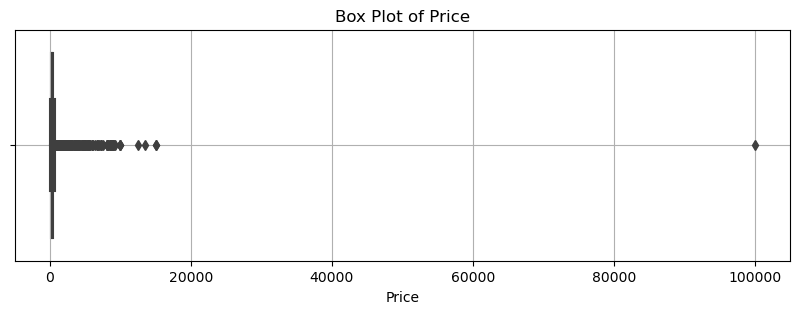

In [107]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=listings_cleaned['price'])
plt.xlabel('Price')
plt.title('Box Plot of Price')
plt.grid(True)
plt.show()

In [108]:
listings_cleaned[listings_cleaned['price'] > 10000]

,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
4706,46698806,10552268,Cristina,2013-12-10,"Mooresville, NC",within an hour,94%,72%,t,6.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,4.5,0.933333,0.966667,0.977778,0.994521
7391,53810192,430653443,Reginald,2021-11-06,"Miramar, FL",within a day,89%,0%,f,1.0,...,4.64000,4.790000,4.790000,4.790000,0.620000,2.0,1.000000,1.000000,1.000000,1.000000
7752,539000625832293175,408615863,Max,2021-06-22,NaN,within a day,90%,81%,t,22.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,3.0,1.000000,1.000000,1.000000,0.997260
10753,727521786498618311,268830423,Janit,2019-06-15,"Bear Creek, WI",within a day,100%,0%,f,3.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,1.0,1.000000,1.000000,1.000000,1.000000
12210,806381631034673979,31852158,Jay,2015-04-24,NaN,within an hour,100%,97%,f,7.0,...,5.00000,5.000000,5.000000,5.000000,0.190000,10.0,1.000000,1.000000,1.000000,0.997260


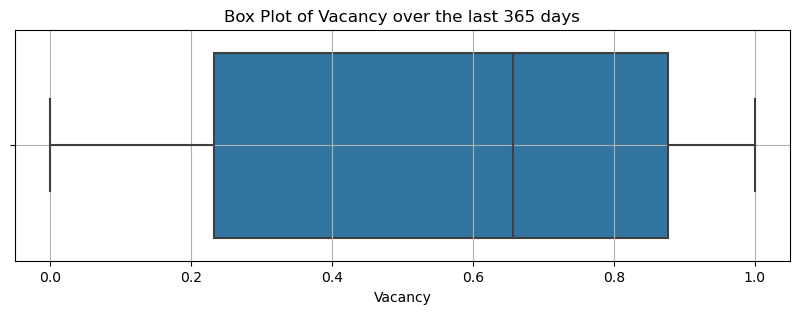

In [109]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=listings_cleaned['vacancy_rate_365'])
plt.xlabel('Vacancy')
plt.title('Box Plot of Vacancy over the last 365 days')
plt.grid(True)
plt.show()

Looking for outliers in the price, there's a better way to filter the dataframe and eliminate the price outlier if we just remove all listings that have ~100% vacancy 

In [110]:
listings_cleaned.shape

(18230, 46)

In [111]:
listings_cleaned = listings_cleaned[listings_cleaned['vacancy_rate_365'] <= .999]

In [112]:
listings_cleaned.shape

(17795, 46)

In [113]:
18230-17795

435

Eliminated 435 outliers who have been completely or almost completely vacant for a year

<h1>Clustering listings

To cluster listings, we'll first create a seperate dataframe with only the information on the listings. We're going to include the listing ID, all the relevant numerical information on the listing itself, as well as the property & room type which we'll one-hot-encode.

In [114]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [115]:
#id column
id_features = [] #['id'] #the id feature was not getting standard scaled & was messing up the PCA

#numerical columns
num_features = ['price', 'latitude', 'longitude', 'vacancy_rate_365', 
              'accommodates', 'beds', 'minimum_nights', 'maximum_nights',
             'number_of_reviews','number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 
              'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
              'review_scores_location', 'review_scores_value', 'reviews_per_month', 'bathrooms']

#categorical columns
cat_features = ['room_type']

In [116]:
listings_cleaned['property_type'].unique()

array(['Entire home', 'Entire rental unit', 'Entire condo',
       'Private room in guest suite', 'Private room in guesthouse',
       'Private room in condo', 'Entire townhouse', 'Entire guest suite',
       'Private room in rental unit', 'Private room in home',
       'Private room in bed and breakfast', 'Entire villa',
       'Private room in townhouse', 'Entire cottage',
       'Entire serviced apartment', 'Entire cabin',
       'Room in boutique hotel', 'Private room in resort',
       'Room in bed and breakfast', 'Private room in villa',
       'Entire bungalow', 'Entire guesthouse', 'Entire chalet',
       'Private room', 'Entire place', 'Room in aparthotel',
       'Room in hotel', 'Private room in bungalow', 'Camper/RV', 'Barn',
       'Room in serviced apartment', 'Room in resort', 'Boat',
       'Casa particular', 'Private room in tiny home',
       'Private room in farm stay', 'Private room in loft', 'Entire loft',
       'Entire resort', 'Private room in casa particular', 

In [117]:
listings_cleaned['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

The number of categories in the property type column is unruly & seems unreliable. We will drop the column

We'll need to standardize the numerical columns and one-hot-encode the categorical columns

In [118]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
        ('passthrough', 'passthrough', id_features)
    ])

transformed_data = preprocessor.fit_transform(listings_cleaned)

# Convert the transformed data back to a DataFrame
# Get feature names for one-hot encoded columns
encoded_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
all_columns = list(num_features) + list(encoded_columns) + id_features
transformed_df = pd.DataFrame(transformed_data, columns=all_columns)

<h2>PCA & Kmeans

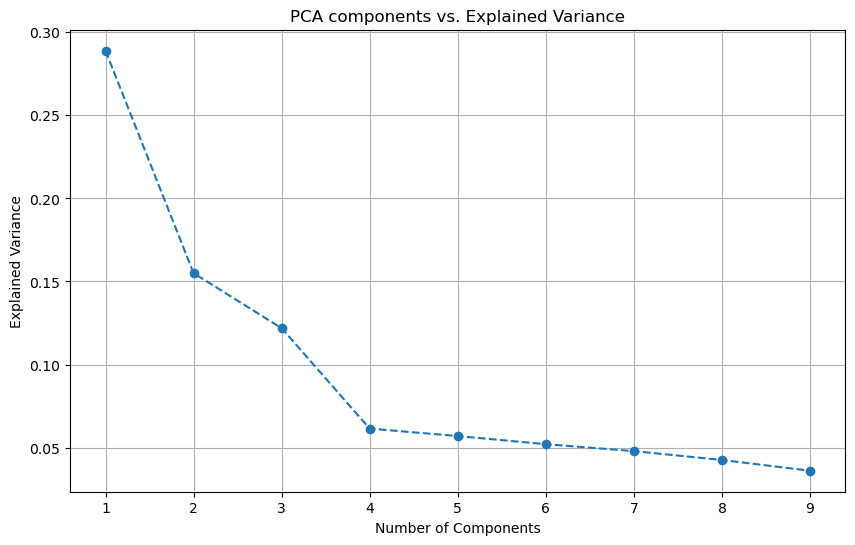

In [119]:
pca = PCA()
pca.fit(transformed_df)
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), explained_variance_ratio[0:9], marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA components vs. Explained Variance')
plt.grid(True)
plt.show()

<h2>PCA: 2 Components

In [120]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(transformed_df.drop(columns=id_features))

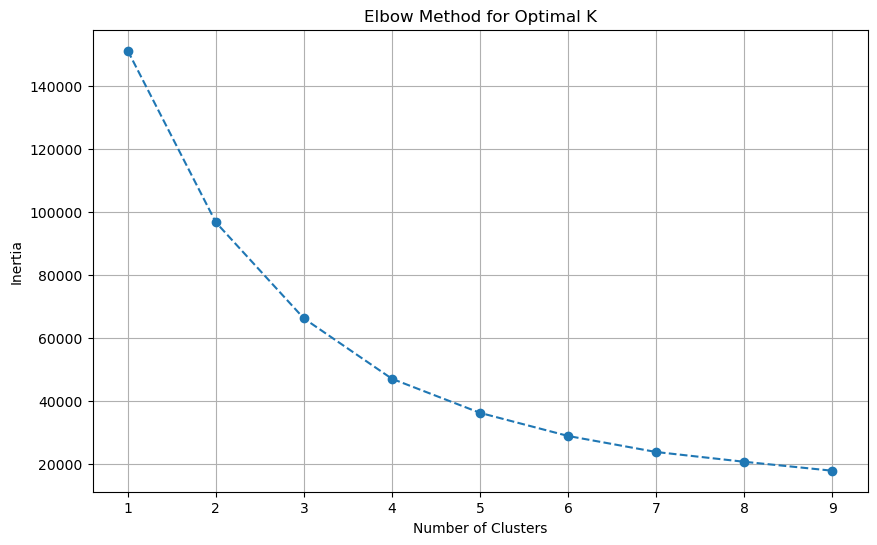

In [121]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

We will choose 4 clusters

In [122]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_data)
clusters = kmeans.labels_

transformed_df['cluster'] = clusters

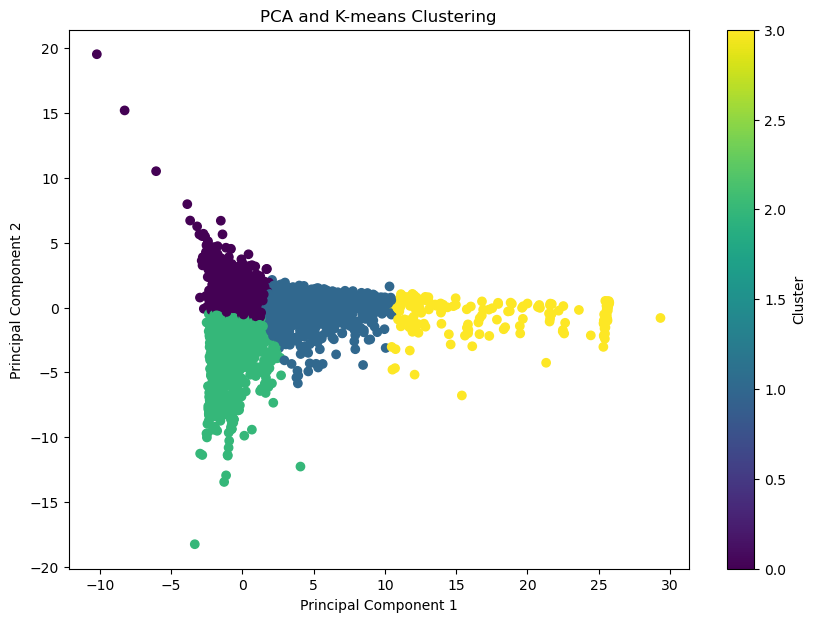

In [123]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA and K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [124]:
tf_df_kmeans = transformed_df.copy()
tf_df_kmeans['cluster'] = clusters

cluster_summary = tf_df_kmeans.groupby('cluster').mean()

print("Cluster Summary Statistics (Mean):")
cluster_summary

Cluster Summary Statistics (Mean):


,price,latitude,longitude,vacancy_rate_365,accommodates,beds,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,room_type_Hotel room,room_type_Private room,room_type_Shared room
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.265026,0.034377,-0.023350,-0.102319,-0.465728,-0.444636,0.028777,-0.056391,0.117218,0.103198,...,0.188116,0.162203,0.178823,0.139414,0.201020,0.122816,-0.410515,0.003048,0.198729,0.004354
1,-0.166765,-0.450218,0.002032,0.232146,-0.199079,-0.205150,-0.047596,-0.003601,-0.313222,-0.351398,...,-1.479304,-1.236802,-1.304311,-1.048541,-1.572740,-0.500140,-0.264719,0.002676,0.141806,0.010702
2,0.712959,0.069048,0.065478,0.182188,1.220587,1.170817,-0.052579,0.147340,-0.171451,-0.122121,...,0.231638,0.229508,0.218582,0.189589,0.239962,-0.116430,1.105127,0.000215,0.030726,0.000645
3,-0.156484,-0.263962,-0.243229,-0.122872,-0.214911,-0.224100,-0.089491,-0.201192,-0.489684,-0.560353,...,-6.298294,-6.636164,-6.875805,-5.617604,-6.588012,-0.740647,-0.205947,0.006135,0.220859,0.006135


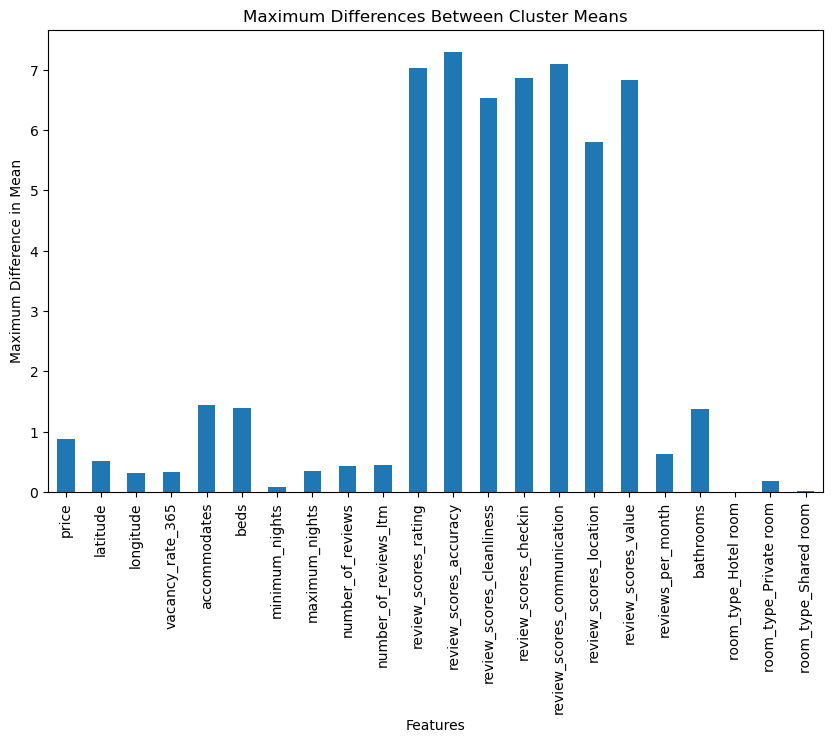

In [125]:
differences = cluster_summary.diff().abs().iloc[1:]
max_differences = differences.max()

max_differences.plot(kind='bar', figsize=(10, 6), title='Maximum Differences Between Cluster Means')
plt.xlabel('Features')
plt.ylabel('Maximum Difference in Mean')
plt.show()

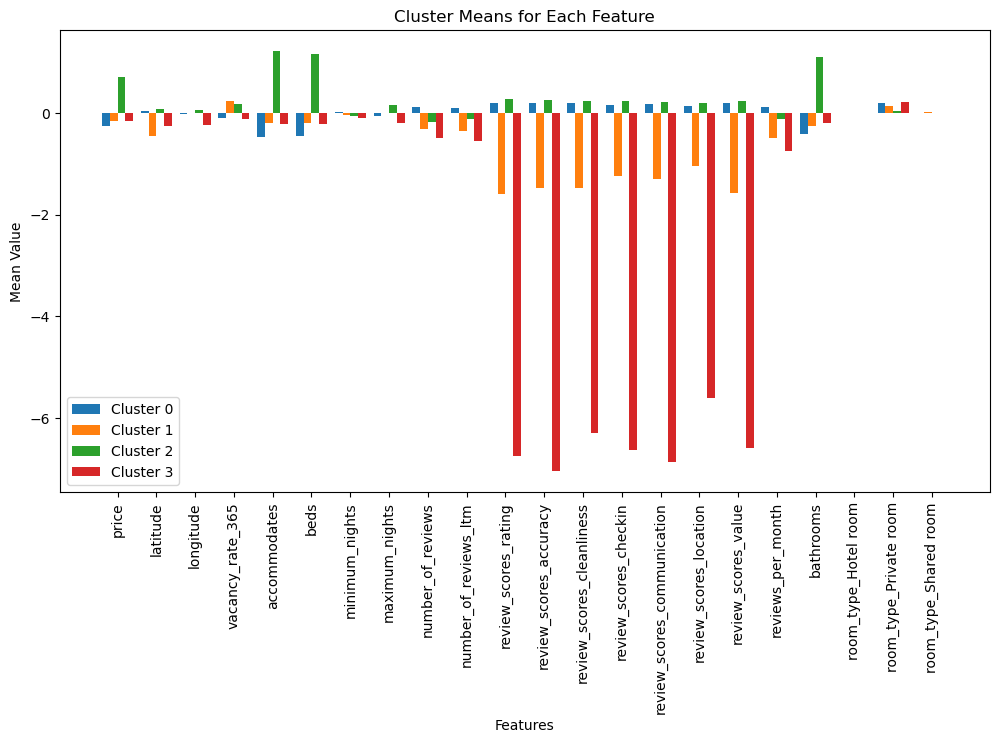

In [126]:
cluster_means = cluster_summary.copy()
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

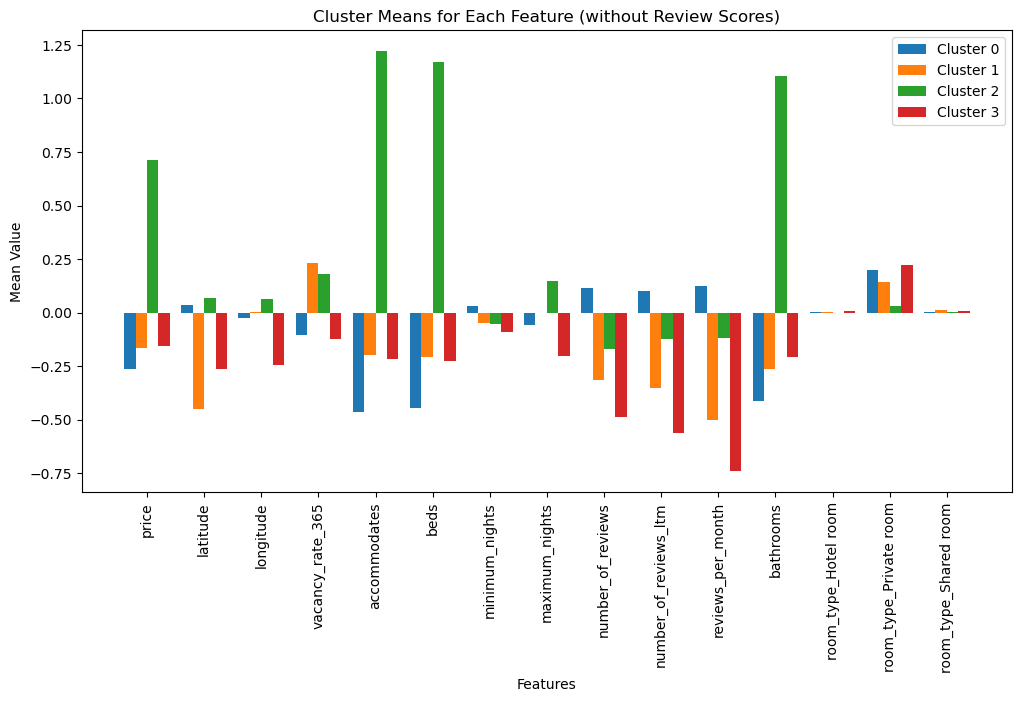

In [127]:
cluster_means = cluster_summary.copy().drop(['review_scores_rating','review_scores_accuracy',
                                             'review_scores_cleanliness', 'review_scores_checkin', 
                                             'review_scores_communication','review_scores_location',
                                            'review_scores_value'], axis=1)
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature (without Review Scores)')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

<h2>Cluster Interpretation</h2>
<br> Cluster 0: Cheapest & smallest (accomodates less) listings that are fairly well reviewed
<br> Cluster 1: Mid priced poorly reviewed listings closer to Miami
<br> Cluster 2: Expensive listings with fairly good reviews that accomodate more people- i.e. more beds & baths
<br> Cluster 3: Mid priced very poorly reviewed listings, accomodates the least of the clusters, closest out of all of the clusters to the beach

<h3>PCA: Components 3

In [128]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(transformed_df.drop(columns=id_features))

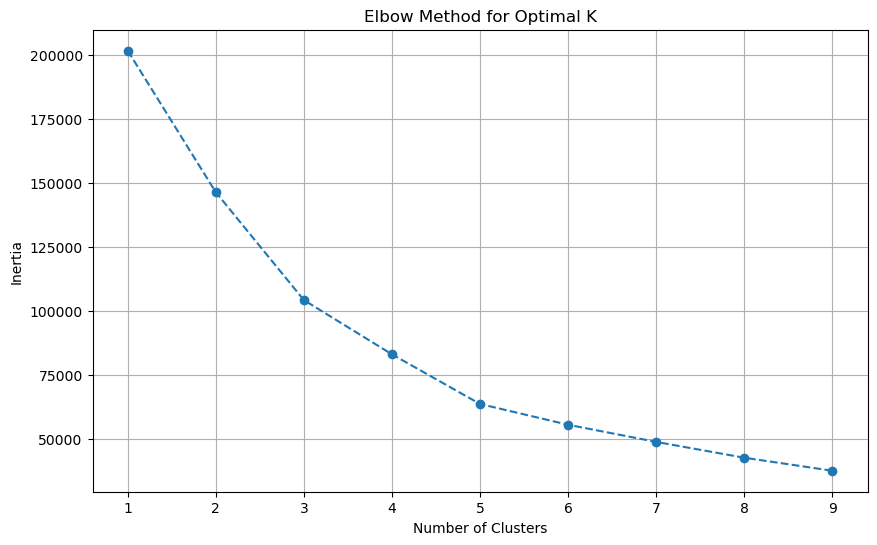

In [129]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [130]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_data)
clusters = kmeans.labels_

transformed_df['cluster'] = clusters

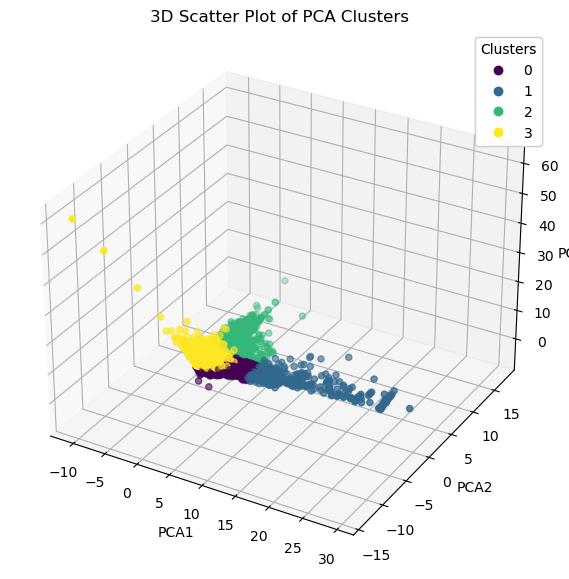

In [131]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=transformed_df['cluster'], cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('3D Scatter Plot of PCA Clusters')
plt.show()


In [132]:
import imageio
import os


In [133]:
if not os.path.exists('frames'):
    os.makedirs('frames')

# Capture frames while rotating the plot
filenames = []
for angle in range(0, 360, 4):  # Rotate from 0 to 180 degrees in increments of 2 degrees
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=transformed_df['cluster'], cmap='viridis')

    # Add legend
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('PCA Clusters for Listings')

    ax.view_init(elev=10., azim=angle)

    # Save frame
    filename = f'frames/frame_{angle}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

In [134]:
with imageio.get_writer('listings_3D_cluster.gif', mode='I', duration=0.1, loop =0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)



In [135]:
# Clean up: Remove frames folder and images
import shutil
shutil.rmtree('frames')

In [136]:
tf_df_kmeans_pca3 = transformed_df.copy()
tf_df_kmeans_pca3['cluster'] = clusters

cluster_summary = tf_df_kmeans_pca3.groupby('cluster').mean()

print("Cluster Summary Statistics (Mean):")
cluster_summary

Cluster Summary Statistics (Mean):


,price,latitude,longitude,vacancy_rate_365,accommodates,beds,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,room_type_Hotel room,room_type_Private room,room_type_Shared room
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.259134,-0.030737,-0.035088,-0.032581,-0.466550,-0.446308,0.061756,-0.090082,-0.245747,-0.294184,...,0.020508,0.017105,0.035893,0.036407,0.025260,-0.247507,-0.409520,0.003254,0.209131,0.005456
1,-0.143013,-0.331143,-0.117501,0.029427,-0.231798,-0.231188,-0.067326,-0.122268,-0.466816,-0.517468,...,-4.090925,-4.190403,-4.451301,-3.559100,-4.496513,-0.649648,-0.238561,0.004902,0.181373,0.019608
2,0.710927,0.058665,0.063913,0.188235,1.222683,1.173063,-0.053658,0.146424,-0.182434,-0.140534,...,0.190488,0.207271,0.190732,0.167168,0.198823,-0.136485,1.102705,0.000423,0.031065,0.000634
3,-0.271106,0.080945,0.050794,-0.254793,-0.370027,-0.359575,-0.164859,0.135108,1.640827,1.789654,...,0.250763,0.249280,0.244029,0.127183,0.285380,1.584439,-0.381514,0.001359,0.120979,0.000906


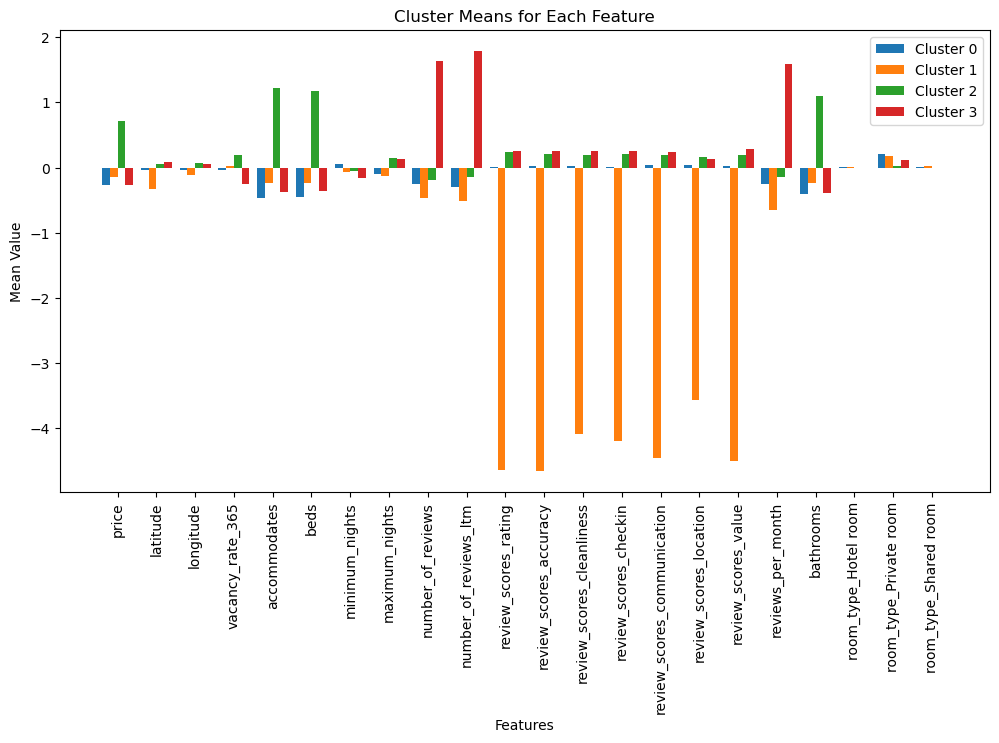

In [137]:
cluster_means = cluster_summary.copy()
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

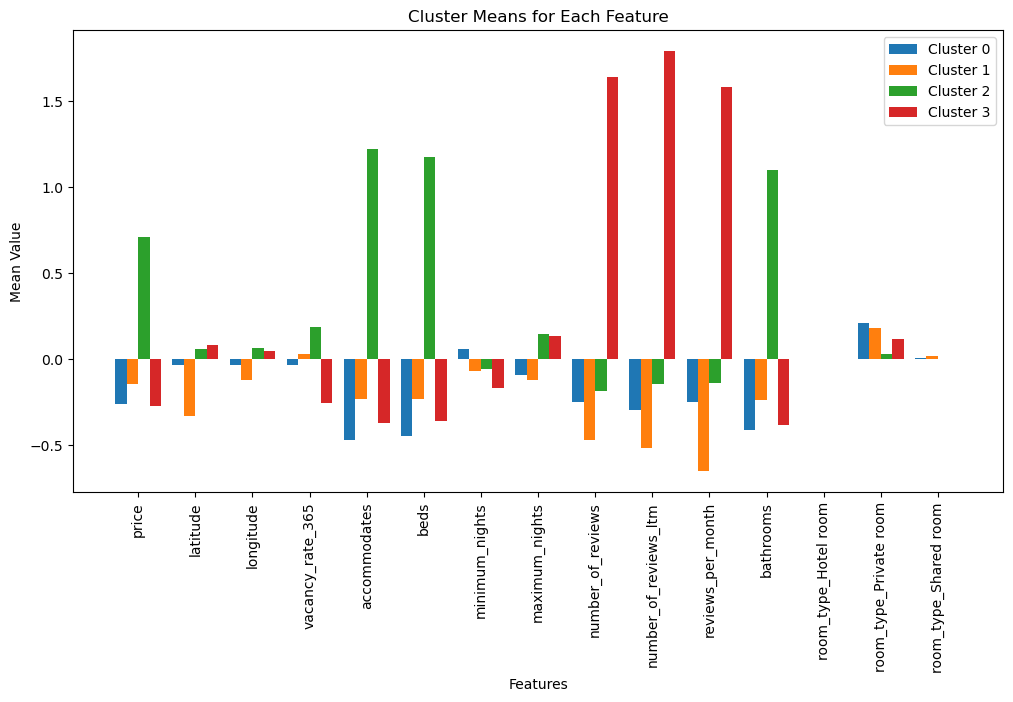

In [138]:
cluster_means = cluster_summary.copy().drop(['review_scores_rating','review_scores_accuracy',
                                             'review_scores_cleanliness', 'review_scores_checkin', 
                                             'review_scores_communication','review_scores_location',
                                            'review_scores_value'], axis=1)
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

<h3>Cluster Interpretation</h3>
<br> Cluster 0: //
<br> Cluster 1: //
<br> Cluster 2: //
<br> Cluster 3: //

In [139]:
cluster_summary_1 = cluster_summary.copy().drop(['review_scores_accuracy',
                                             'review_scores_cleanliness', 'review_scores_checkin', 
                                             'review_scores_communication','review_scores_location',
                                            'review_scores_value'], axis=1)

output_dir = 'listings_cluster_images'
os.makedirs(output_dir, exist_ok=True)

# Find the overall min and max values for the y-axis
y_min = cluster_summary_1.min().min()
y_max = cluster_summary_1.max().max()

# Loop through each cluster and create a graph
for index, row in cluster_summary_1.iterrows():
    plt.figure()
    row.plot(kind='bar')
    plt.title(f'Cluster {index}')
    plt.xlabel('Features')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=90)
    
    # Set consistent y-axis limits & tight layout
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    
    # Save the plot as an image
    filename = os.path.join(output_dir, f'cluster_{index}.png')
    plt.savefig(filename)
    plt.close()
    
directory = output_dir

files = os.listdir(directory)
filenames = []
filenames = [file for file in files if os.path.isfile(os.path.join(directory, file))]


os.chdir(directory)
with imageio.get_writer('clusters.gif', mode='I', loop =0, duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        for idx in range(0,75): #workaround for image duration
            writer.append_data(image)
os.chdir('..')

<h1>PCA & K-Medoids

Calculating k-medoids at level 1
Calculating k-medoids at level 2
Calculating k-medoids at level 3
Calculating k-medoids at level 4
Calculating k-medoids at level 5
Calculating k-medoids at level 6
Calculating k-medoids at level 7
Calculating k-medoids at level 8
Calculating k-medoids at level 9


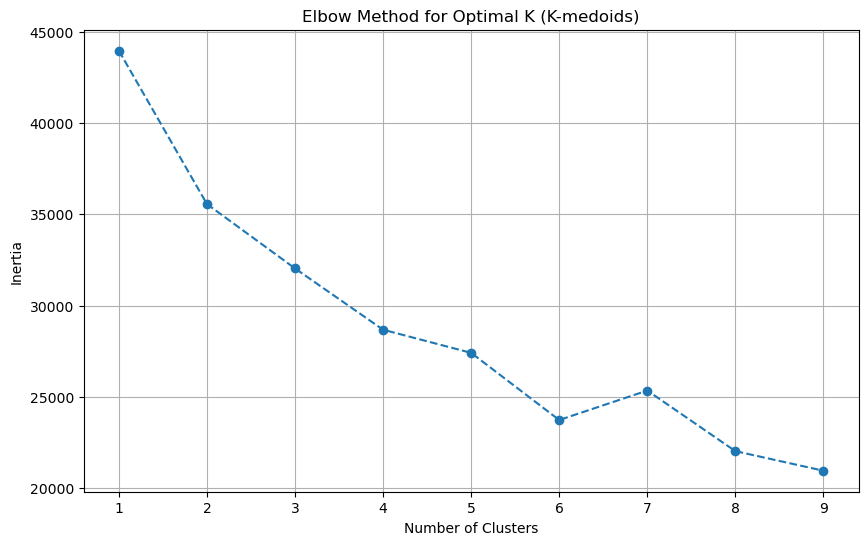

In [140]:
inertia = []
for k in range(1, 10):
    print('Calculating k-medoids at level ' + str(k)) #print progress because the process takes a while
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(pca_data)
    inertia.append(kmedoids.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (K-medoids)')
plt.grid(True)
plt.show()

In [141]:
# Fit K-medoids clustering with the optimal number of clusters
optimal_k = 4
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42)
kmedoids.fit(pca_data)
clusters = kmedoids.labels_

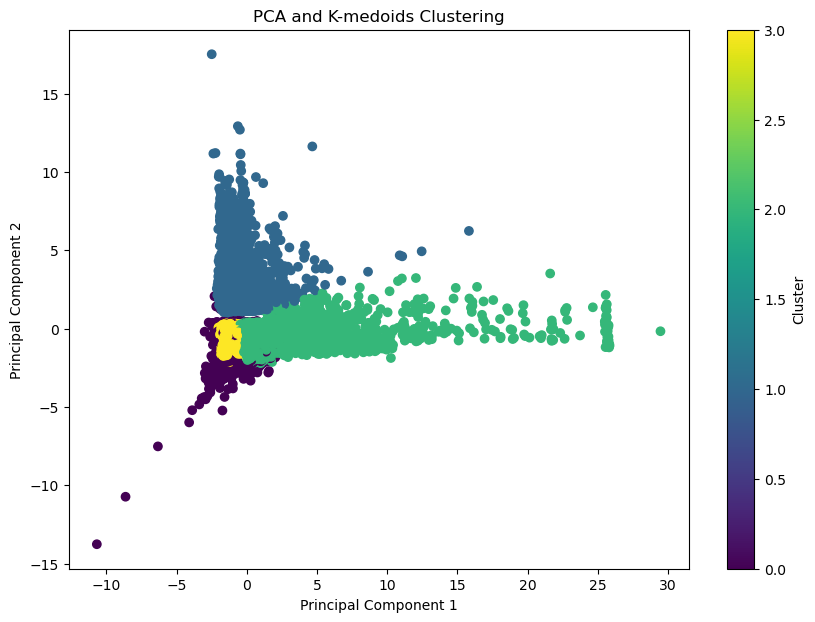

In [142]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA and K-medoids Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [143]:
# Get indices of medoids in the original DataFrame
medoid_indices = kmedoids.medoid_indices_

# Print the indices of medoids
print("Indices of Medoids in the Original DataFrame:")
for cluster_id, index in enumerate(medoid_indices):
    print(f"Cluster {cluster_id}: Index {index}")

# Print the corresponding rows in the original DataFrame (optional)
print("\nCorresponding Rows in the Original DataFrame:")
listings_cleaned.iloc[medoid_indices]

Indices of Medoids in the Original DataFrame:
Cluster 0: Index 6666
Cluster 1: Index 7588
Cluster 2: Index 1981
Cluster 3: Index 4902

Corresponding Rows in the Original DataFrame:


,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
6794,52632709,65799752,Valeria,2016-04-04,"Hollywood, FL",within an hour,100%,99%,t,2.0,...,4.89,4.97,4.93,4.78,2.67,1.0,0.300000,0.150000,0.244444,0.260274
7740,520285086418937552,229764405,Nir,2018-12-08,"Hollywood, FL",within an hour,100%,100%,t,4.0,...,4.80,4.90,4.80,4.70,0.82,2.0,0.266667,0.566667,0.711111,0.928767
2022,28710428,22238827,Veronika,2014-10-07,"Miami, FL",NaN,NaN,100%,f,5.0,...,4.84,4.47,4.86,4.70,0.69,1.0,0.700000,0.800000,0.777778,0.936986
4982,47716138,384374494,Sheena,2021-01-13,"Lauderdale-by-the-Sea, FL",within a few hours,80%,97%,f,4.0,...,4.93,4.86,5.00,4.93,0.42,2.0,0.000000,0.000000,0.011111,0.139726


In [144]:
tf_df_kmedoids = transformed_df.copy()
tf_df_kmedoids['cluster'] = clusters

cluster_summary = tf_df_kmedoids.groupby('cluster').mean()
cluster_summary2 = tf_df_kmedoids.groupby('cluster').var()


print("Cluster Summary Statistics (Mean):")
cluster_summary.iloc[:,4:]

Cluster Summary Statistics (Mean):


,accommodates,beds,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,room_type_Hotel room,room_type_Private room,room_type_Shared room
cluster,,,,,,,,,,,,,,,,,,
0,-0.365365,-0.358162,-0.159533,0.109487,1.423835,1.581040,0.244438,0.253368,0.239569,0.238142,0.240413,0.116783,0.272586,1.388972,-0.377686,0.001109,0.115669,0.000739
1,1.226704,1.176980,-0.057176,0.147643,-0.180508,-0.137523,0.250740,0.220130,0.196959,0.206680,0.195483,0.168733,0.206747,-0.132238,1.107824,0.000425,0.031237,0.000637
2,-0.415920,-0.408073,0.070884,-0.090101,-0.320310,-0.396432,-0.592247,-0.548828,-0.541917,-0.486306,-0.484235,-0.409840,-0.574921,-0.247094,-0.386877,0.003648,0.211886,0.008664
3,-0.538341,-0.495522,0.061625,-0.104707,-0.235569,-0.268922,0.540210,0.496633,0.523162,0.415972,0.424626,0.416998,0.544647,-0.397112,-0.432738,0.003155,0.215300,0.002103


In [145]:
print("Cluster Summary Statistics (Variance):")
cluster_summary2.iloc[:,4:]

Cluster Summary Statistics (Variance):


,accommodates,beds,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,room_type_Hotel room,room_type_Private room,room_type_Shared room
cluster,,,,,,,,,,,,,,,,,,
0,0.380560,0.319871,0.023588,1.253931,3.285138,2.351102,0.125663,0.097069,0.140203,0.095562,0.075872,0.184931,0.111831,2.712845,0.250952,0.001108,0.102327,0.000739
1,0.870897,1.213767,0.318915,0.967201,0.253137,0.403683,0.245958,0.233328,0.349059,0.234490,0.235930,0.308446,0.310215,0.392431,1.509833,0.000425,0.030267,0.000637
2,0.304114,0.241851,1.119067,0.877034,0.109664,0.132413,1.851526,1.959702,1.835131,2.067569,2.093592,2.003986,1.799598,0.197428,0.221311,0.003635,0.167016,0.008590
3,0.258794,0.192536,2.297587,1.013192,0.123851,0.132191,0.063955,0.058386,0.102772,0.069463,0.037675,0.190345,0.128834,0.264870,0.183546,0.003145,0.168990,0.002099


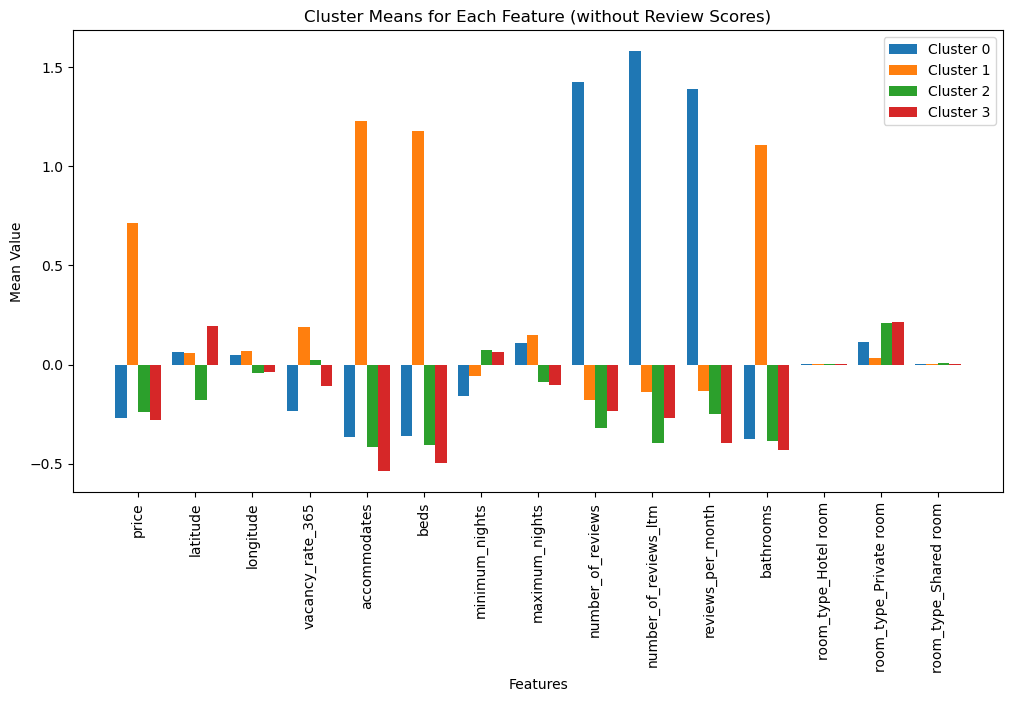

In [146]:
cluster_means = cluster_summary.copy().drop(['review_scores_rating','review_scores_accuracy',
                                             'review_scores_cleanliness', 'review_scores_checkin', 
                                             'review_scores_communication','review_scores_location',
                                            'review_scores_value'], axis=1)
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature (without Review Scores)')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

<h3>K-means vs K-Medoids

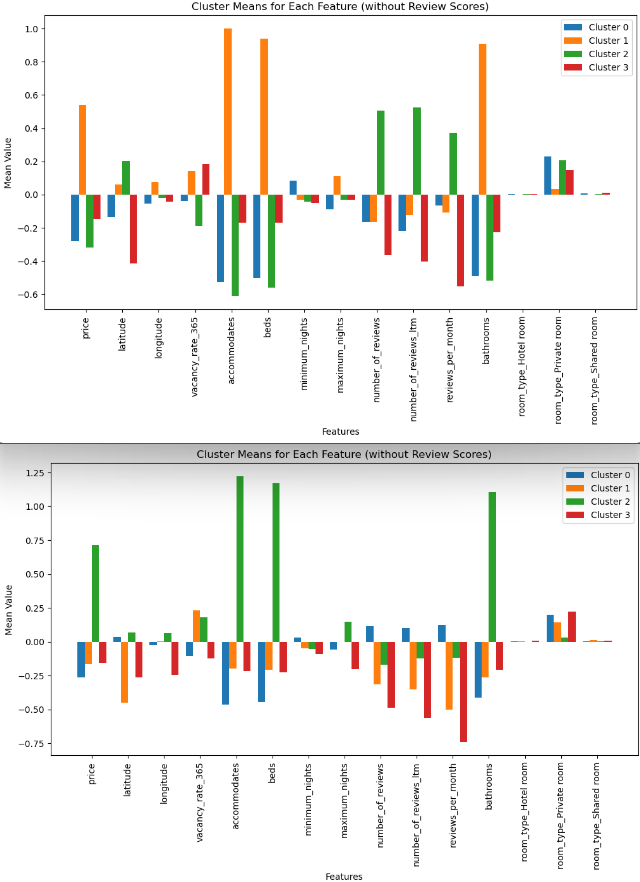

In [147]:
from IPython.display import Image, display

image_path = 'kmeans_v_kmedoids.png'

display(Image(filename=image_path))

Kmedoids is on top, Kmeans on the bottom
<br>Some change in the reviews clustering, but overall very similar

<h1> Host Segmentation

In [148]:
listings_cleaned.columns

Index(['id', 'host_id', 'host_name', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month',
       'bathrooms', 'vacancy_rate_30', 'vacancy_rate_60', 'vacancy_rate_90',
       'vacancy_rate_365'

In [149]:
listings_cleaned

,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
0,57818,275948,Von Inc,2010-11-01,"Hollywood, FL",within an hour,100%,96%,t,3.0,...,5.00000,4.970000,4.880000,4.710000,0.430000,1.0,0.066667,0.033333,0.111111,0.586301
1,69824,351303,Tracy,2011-01-17,"Silver Spring, MD",within an hour,100%,50%,f,3.0,...,4.75000,4.750000,5.000000,4.500000,0.120000,2.0,0.633333,0.316667,0.211111,0.769863
2,83449,454736,"Jon, Mary Pop Apartments",2011-03-21,"Dania Beach, FL",within an hour,100%,97%,f,17.0,...,4.94000,4.900000,4.810000,4.870000,0.210000,1.0,0.000000,0.016667,0.011111,0.002740
3,105411,532930,Sonia,2011-04-25,"Southwest Ranches, FL",within an hour,80%,57%,f,3.0,...,5.00000,5.000000,4.250000,5.000000,0.030000,2.0,0.800000,0.900000,0.933333,0.983562
4,129099,637272,Bianca,2011-05-28,"Buenos Aires, Argentina",a few days or more,36%,18%,f,9.0,...,4.44000,4.320000,4.540000,4.080000,0.180000,1.5,0.200000,0.300000,0.322222,0.832877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18225,1053585835624760405,156208082,Albert Milton,2017-10-25,"Aventura, FL",within an hour,100%,100%,f,71.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,2.0,0.900000,0.933333,0.955556,0.728767
18226,1053681377817512389,81648943,Jennifer,2016-07-04,"Las Vegas, NV",within an hour,100%,99%,f,46.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,2.0,0.833333,0.916667,0.944444,0.232877
18227,1053723605446476408,447235921,Traverse,2022-02-28,NaN,within an hour,100%,66%,f,601.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,1.0,0.833333,0.916667,0.944444,0.479452
18228,1053723856792063092,447235921,Traverse,2022-02-28,NaN,within an hour,100%,66%,f,601.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,1.0,0.700000,0.850000,0.900000,0.468493


In [150]:
listings_cleaned['host_since']

0        2010-11-01
1        2011-01-17
2        2011-03-21
3        2011-04-25
4        2011-05-28
            ...    
18225    2017-10-25
18226    2016-07-04
18227    2022-02-28
18228    2022-02-28
18229    2022-02-28
Name: host_since, Length: 17795, dtype: object

In [151]:
#clean response and acceptance rates
listings_cleaned['host_response_rate'] = listings_cleaned['host_response_rate'].str.rstrip('%').astype('float') / 100
listings_cleaned['host_acceptance_rate'] = listings_cleaned['host_acceptance_rate'].str.rstrip('%').astype('float') / 100

#convert host_since column to days since 
listings_cleaned['host_since'] = pd.to_datetime(listings_cleaned['host_since'])
today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))

# Calculate the difference in days from today to the date
listings_cleaned['host_since'] = (listings_cleaned['host_since'] - today).dt.days

In [152]:
listings_cleaned['host_response_rate'].fillna(listings_cleaned['host_response_rate'].mean(), inplace=True)
listings_cleaned['host_acceptance_rate'].fillna(listings_cleaned['host_acceptance_rate'].mean(), inplace=True)
listings_cleaned = listings_cleaned.dropna(subset=['host_name'])
listings_cleaned['host_is_superhost'].fillna('f', inplace=True)

In [153]:
listings_cleaned.isna().sum()

id                                0
host_id                           0
host_name                         0
host_since                        0
host_location                  4588
host_response_time             1810
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_listings_count               0
host_total_listings_count         0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
beds                              0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                769
availability_30                   0
availability_60                   0
availability_90                   0
availability_365            

In [154]:
hosts = listings_cleaned.groupby('host_id').mean()
hosts.drop(columns=['id'], inplace=True)

In [155]:
#merge in the categorical columns
hosts = hosts.merge(listings_cleaned[['host_id', 'host_is_superhost', 
                                      'host_identity_verified', 'host_response_time']], on='host_id', how='right')
hosts

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,...,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365,host_is_superhost,host_identity_verified,host_response_time
0,275948,-5013.0,1.00,0.96,3.0,3.0,26.018582,-80.125284,3.000000,1.500000,...,4.683413,0.920512,1.000000,0.033333,0.025000,0.161111,0.695890,t,t,within an hour
1,351303,-4936.0,1.00,0.50,3.0,5.0,25.977355,-80.119365,6.000000,3.500000,...,4.665000,0.155000,2.000000,0.500000,0.250000,0.183333,0.760274,f,t,within an hour
2,454736,-4873.0,1.00,0.97,17.0,20.0,26.033855,-80.141757,3.666667,2.333333,...,4.701577,0.456136,1.066667,0.466667,0.357778,0.260741,0.067397,f,t,within an hour
3,532930,-4838.0,0.80,0.57,3.0,3.0,26.047500,-80.366680,5.000000,3.000000,...,5.000000,0.030000,2.000000,0.800000,0.900000,0.933333,0.983562,f,t,within an hour
4,637272,-4805.0,0.36,0.18,9.0,19.0,25.993170,-80.117884,5.600000,2.800000,...,4.447365,0.408205,1.700000,0.580000,0.730000,0.777778,0.945205,f,t,a few days or more
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17786,156208082,-2463.0,1.00,1.00,71.0,115.0,26.040105,-80.169898,11.659091,8.590909,...,4.744878,2.286322,2.090909,0.436364,0.567424,0.619444,0.398070,f,t,within an hour
17787,81648943,-2941.0,1.00,0.99,46.0,56.0,26.063376,-80.200600,2.767442,1.744186,...,4.353068,0.946565,1.546512,0.607752,0.743023,0.797674,0.687098,f,t,within an hour
17788,447235921,-876.0,1.00,0.66,601.0,713.0,26.106731,-80.144807,8.750000,4.562500,...,4.656826,1.411024,1.875000,0.614583,0.728125,0.770139,0.428082,f,t,within an hour
17789,447235921,-876.0,1.00,0.66,601.0,713.0,26.106731,-80.144807,8.750000,4.562500,...,4.656826,1.411024,1.875000,0.614583,0.728125,0.770139,0.428082,f,t,within an hour


In [156]:
hosts.columns

Index(['host_id', 'host_since', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'bathrooms',
       'vacancy_rate_30', 'vacancy_rate_60', 'vacancy_rate_90',
       'vacancy_rate_365', 'host_is_superhost', 'host_identity_verified',
       'host_response_time'],
      dtype='object')

In [157]:
#id column
id_features = []# ['host_id']

#numerical columns
num_features = ['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count',
                 'price', 'vacancy_rate_365', 
              'accommodates', 'beds', 'minimum_nights', 'maximum_nights',
             'number_of_reviews','number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 
              'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
              'review_scores_location', 'review_scores_value', 'reviews_per_month', 'bathrooms']

#categorical columns
cat_features = ['host_is_superhost', 'host_identity_verified', 'host_response_time']

hosts = hosts[id_features+num_features+cat_features]

In [158]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
        ('passthrough', 'passthrough', id_features)
    ])

transformed_data = preprocessor.fit_transform(hosts)

# Convert the transformed data back to a DataFrame
# Get feature names for one-hot encoded columns
encoded_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
all_columns = list(num_features) + list(encoded_columns) + id_features
transformed_df = pd.DataFrame(transformed_data, columns=all_columns)

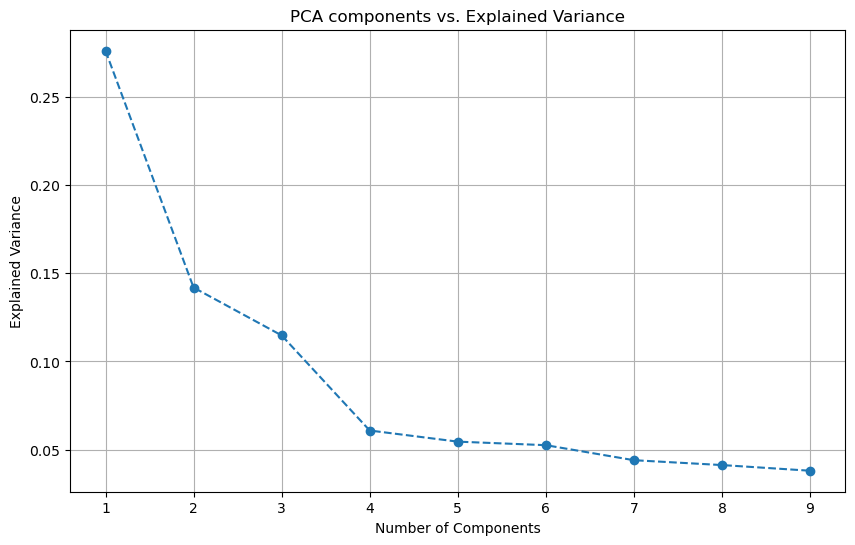

In [159]:
pca = PCA()
pca.fit(transformed_df)
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), explained_variance_ratio[0:9], marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA components vs. Explained Variance')
plt.grid(True)
plt.show()

<h3> PCA 2 Components

In [160]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(transformed_df.drop(columns=id_features))

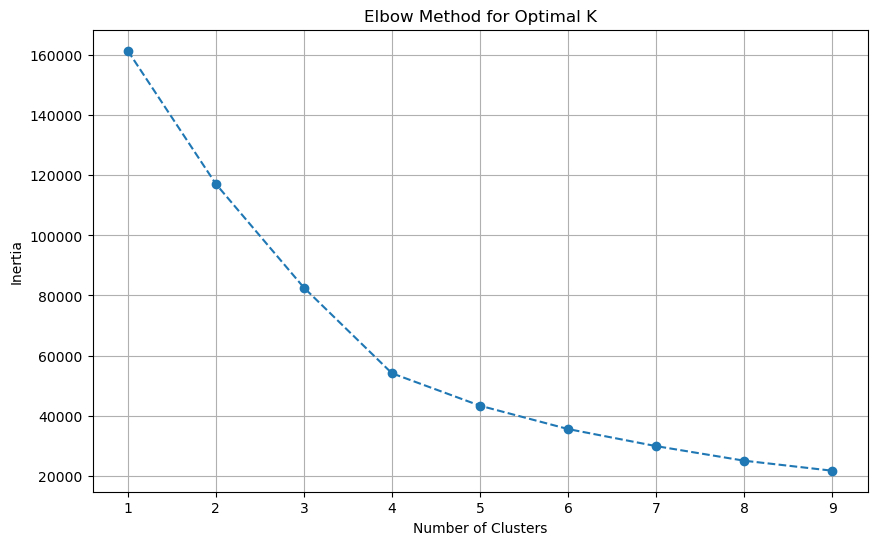

In [161]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [162]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_data)
clusters = kmeans.labels_

transformed_df['cluster'] = clusters

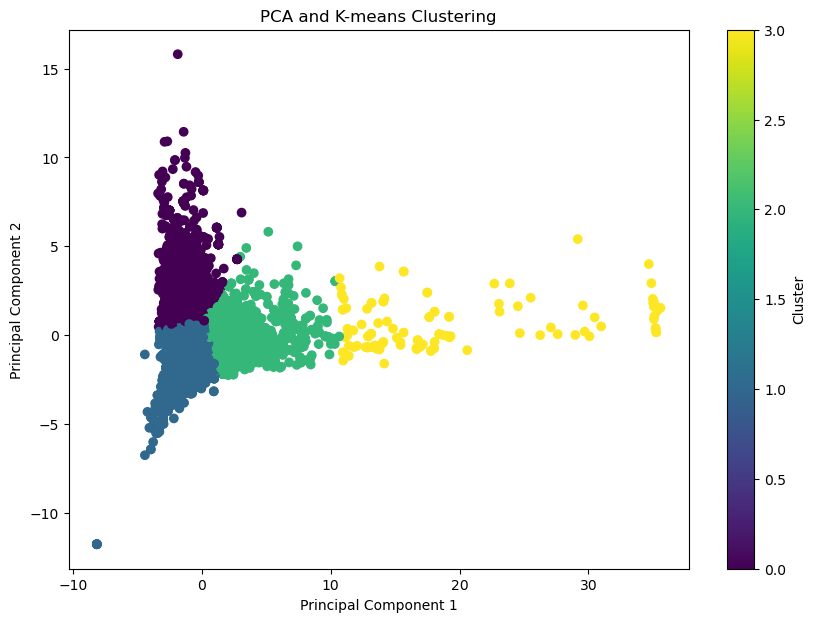

In [163]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA and K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [164]:
hosts_kmeans = hosts.copy()
tf_df_kmeans = transformed_df.copy()
hosts_kmeans['cluster'] = clusters
tf_df_kmeans['cluster'] = clusters

cluster_summary_mean = tf_df_kmeans.groupby('cluster').mean()

print("Cluster Summary Statistics (Mean):")
cluster_summary_mean

Cluster Summary Statistics (Mean):


,host_since,host_response_rate,host_acceptance_rate,host_listings_count,price,vacancy_rate_365,accommodates,beds,minimum_nights,maximum_nights,...,review_scores_location,review_scores_value,reviews_per_month,bathrooms,host_is_superhost_t,host_identity_verified_t,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.155538,0.151879,0.133671,0.214258,0.887779,0.199784,1.341275,1.311656,-0.069287,0.190691,...,0.259579,0.331713,-0.036408,1.273068,0.521332,0.901110,0.027620,0.063872,0.832799,0.069051
1,-0.048321,0.054643,-0.011349,-0.196091,-0.300884,-0.232074,-0.502155,-0.478481,0.058911,-0.093023,...,0.224799,0.368281,0.196925,-0.440221,0.465180,0.870606,0.048001,0.082052,0.723638,0.129833
2,-0.053467,-0.217376,-0.083693,0.209381,-0.184528,0.301330,-0.181585,-0.202834,-0.054939,0.021506,...,-0.515430,-0.854602,-0.344064,-0.249277,0.063787,0.921816,0.043189,0.073311,0.761019,0.065781
3,0.432548,-1.127205,-0.519994,-0.247505,-0.235532,-0.494190,-0.405066,-0.400670,-0.062489,-0.200602,...,-6.598271,-7.174307,-0.783930,-0.248105,0.008547,0.871795,0.102564,0.076923,0.213675,0.435897


In [165]:
cluster_summary_var = tf_df_kmeans.groupby('cluster').var()

print("Cluster Summary Statistics (Variance):")
cluster_summary_var

Cluster Summary Statistics (Variance):


,host_since,host_response_rate,host_acceptance_rate,host_listings_count,price,vacancy_rate_365,accommodates,beds,minimum_nights,maximum_nights,...,review_scores_location,review_scores_value,reviews_per_month,bathrooms,host_is_superhost_t,host_identity_verified_t,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.049149,0.379810,0.604408,2.320738,2.922965,0.757220,0.814791,1.132953,0.298918,0.965326,...,0.221942,0.233460,0.461631,1.373644,0.249607,0.089133,0.026864,0.059807,0.139279,0.064298
1,0.944448,0.721798,1.003931,0.074072,0.116322,1.014799,0.342686,0.273740,1.612921,1.062047,...,0.279197,0.190611,1.469063,0.253263,0.248815,0.112663,0.045702,0.075328,0.200008,0.112989
2,1.039120,1.897730,1.299958,1.543431,0.148268,0.933986,0.337005,0.302010,0.398786,0.854640,...,0.863044,0.636338,0.339296,0.270740,0.059732,0.072087,0.041333,0.067952,0.181909,0.061467
3,0.824973,5.445218,1.698676,0.000699,0.282422,1.524084,0.761739,0.669426,0.271564,1.024848,...,29.545716,10.659045,0.433379,0.609054,0.008547,0.112732,0.092838,0.071618,0.169467,0.248011


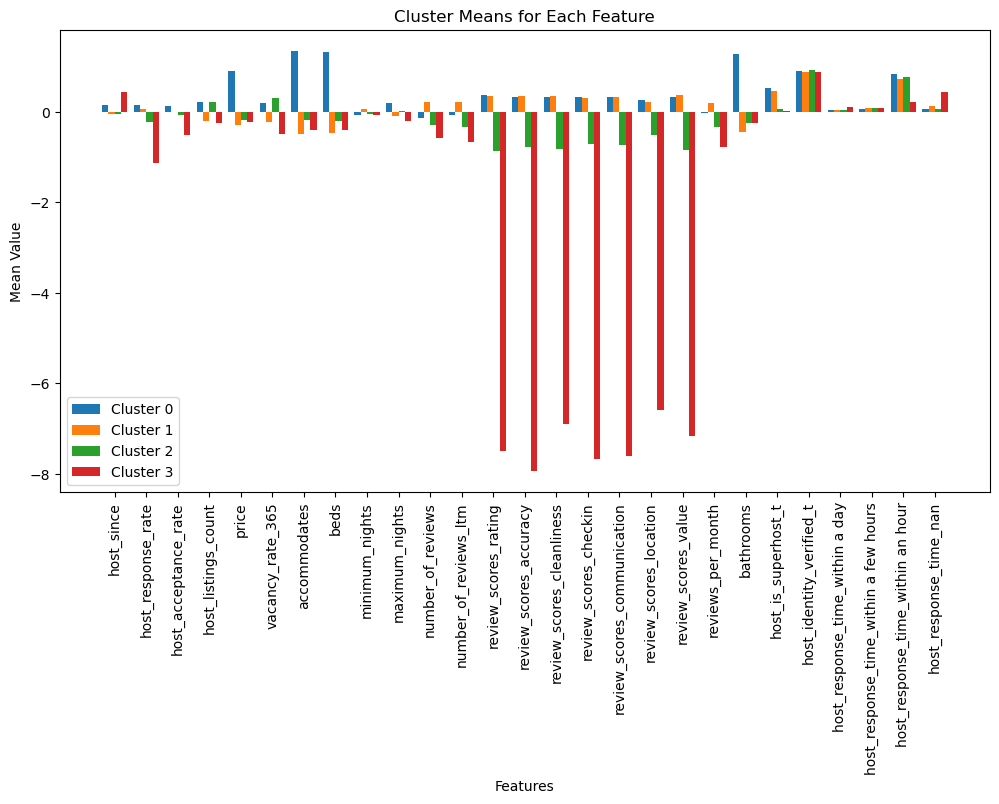

In [166]:
cluster_means = cluster_summary_mean.copy()
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

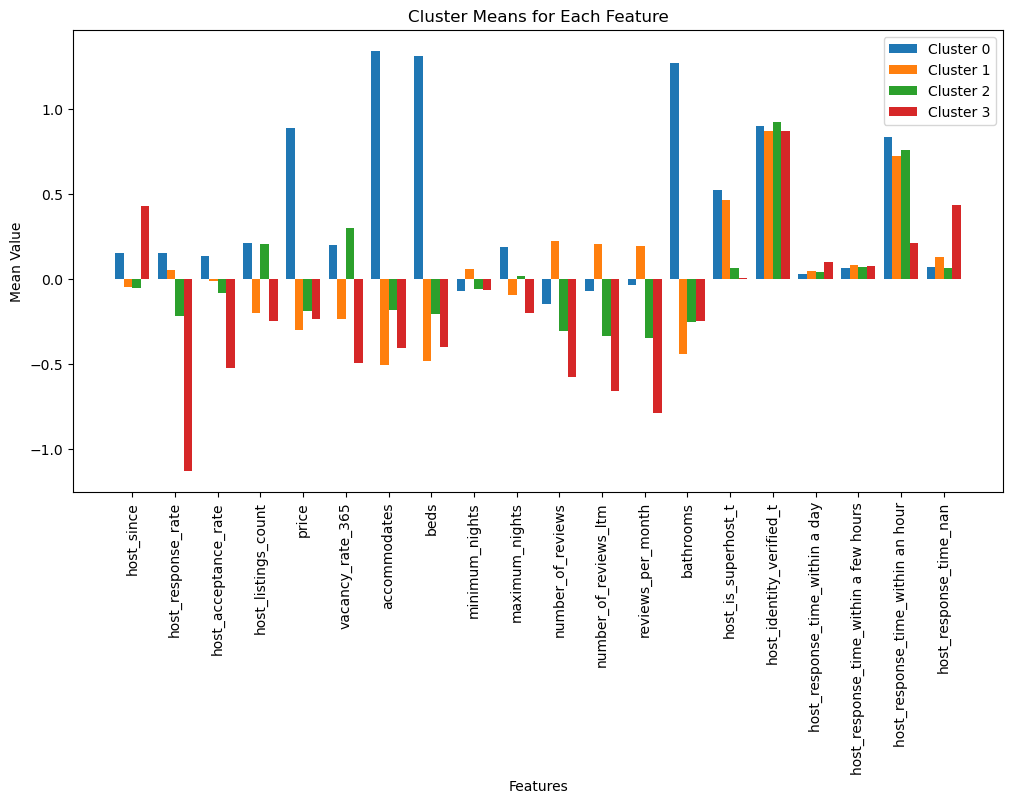

In [167]:
cluster_means = cluster_summary_mean.copy().drop(['review_scores_rating','review_scores_accuracy',
                                             'review_scores_cleanliness', 'review_scores_checkin', 
                                             'review_scores_communication','review_scores_location',
                                            'review_scores_value'], axis=1)
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

<h2>Cluster Interpretation</h2>
<br> Cluster 0: Fairly well reviewed hosts with many large high price listings that accomodate many
<br> Cluster 1: Fairly well reviewed hosts with few smaller low price listings that accomodate fewer
<br> Cluster 2: Fairly poorly reviewed hosts with many mid-price listings. Has been on Airbnb the longest of all the clusters, however few are superhosts.
<br> Cluster 3: Very poorly reviewed hosts with few listings, all with very low reviews, very low response rates, and very low acceptance rates. Generally new to Air BnB, and not a superhost.

<h3> PCA 3 Components

In [168]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(transformed_df.drop(columns=id_features))

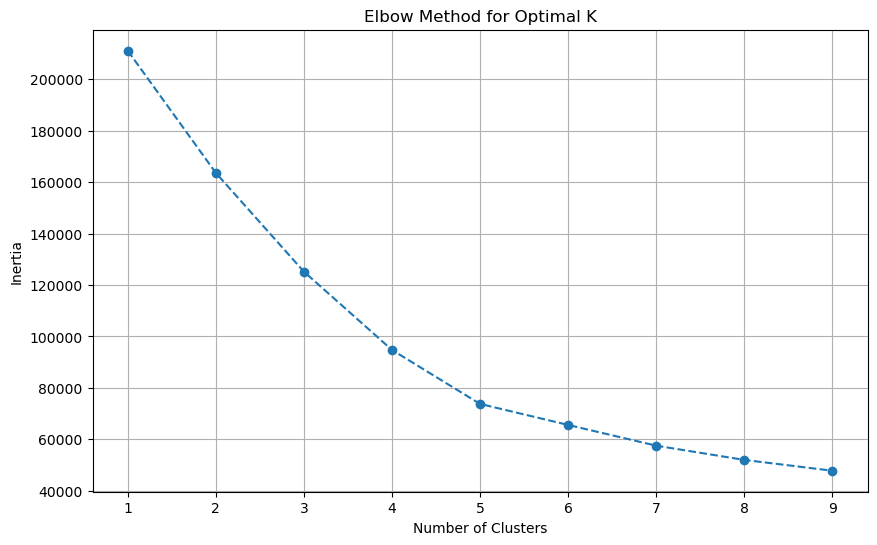

In [169]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [170]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_data)
clusters = kmeans.labels_

transformed_df['cluster'] = clusters

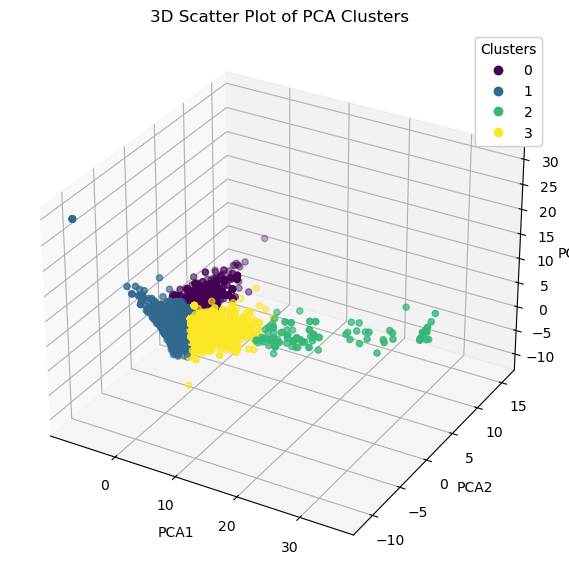

In [171]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=transformed_df['cluster'], cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('3D Scatter Plot of PCA Clusters')
plt.show()


In [172]:
if not os.path.exists('frames'):
    os.makedirs('frames')

# Capture frames while rotating the plot
filenames = []
for angle in range(0, 360, 4):  # Rotate from 0 to 180 degrees in increments of 2 degrees
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=transformed_df['cluster'], cmap='viridis')

    # Add legend
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('PCA Clusters for Hosts')

    ax.view_init(elev=10., azim=angle)

    # Save frame
    filename = f'frames/frame_{angle}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

In [173]:
with imageio.get_writer('hosts_3D_cluster.gif', mode='I', duration=0.1, loop =0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

shutil.rmtree('frames')

In [174]:
tf_df_kmeans_pca3 = transformed_df.copy()
tf_df_kmeans_pca3['cluster'] = clusters

cluster_summary = tf_df_kmeans_pca3.groupby('cluster').mean()

print("Cluster Summary Statistics (Mean):")
cluster_summary

Cluster Summary Statistics (Mean):


,host_since,host_response_rate,host_acceptance_rate,host_listings_count,price,vacancy_rate_365,accommodates,beds,minimum_nights,maximum_nights,...,review_scores_location,review_scores_value,reviews_per_month,bathrooms,host_is_superhost_t,host_identity_verified_t,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.158873,0.160539,0.152422,0.213083,0.888040,0.198794,1.349592,1.321142,-0.077126,0.190496,...,0.249659,0.328013,-0.009032,1.273835,0.528730,0.902343,0.025894,0.063132,0.838718,0.065845
1,-0.052812,0.071077,-0.007227,-0.195303,-0.300219,-0.235275,-0.502793,-0.479736,0.053519,-0.092892,...,0.230736,0.371441,0.186589,-0.438783,0.464136,0.871000,0.047892,0.082763,0.724123,0.131649
2,0.442404,-1.127413,-0.501132,-0.247439,-0.231513,-0.489648,-0.395071,-0.394671,-0.062928,-0.194104,...,-6.605008,-7.202204,-0.781424,-0.243049,0.008621,0.870690,0.103448,0.068966,0.215517,0.439655
3,-0.047601,-0.255441,-0.108480,0.205021,-0.187267,0.303368,-0.190974,-0.211513,-0.036189,0.020149,...,-0.512750,-0.847003,-0.343046,-0.254707,0.062966,0.919482,0.044976,0.072839,0.754278,0.065599


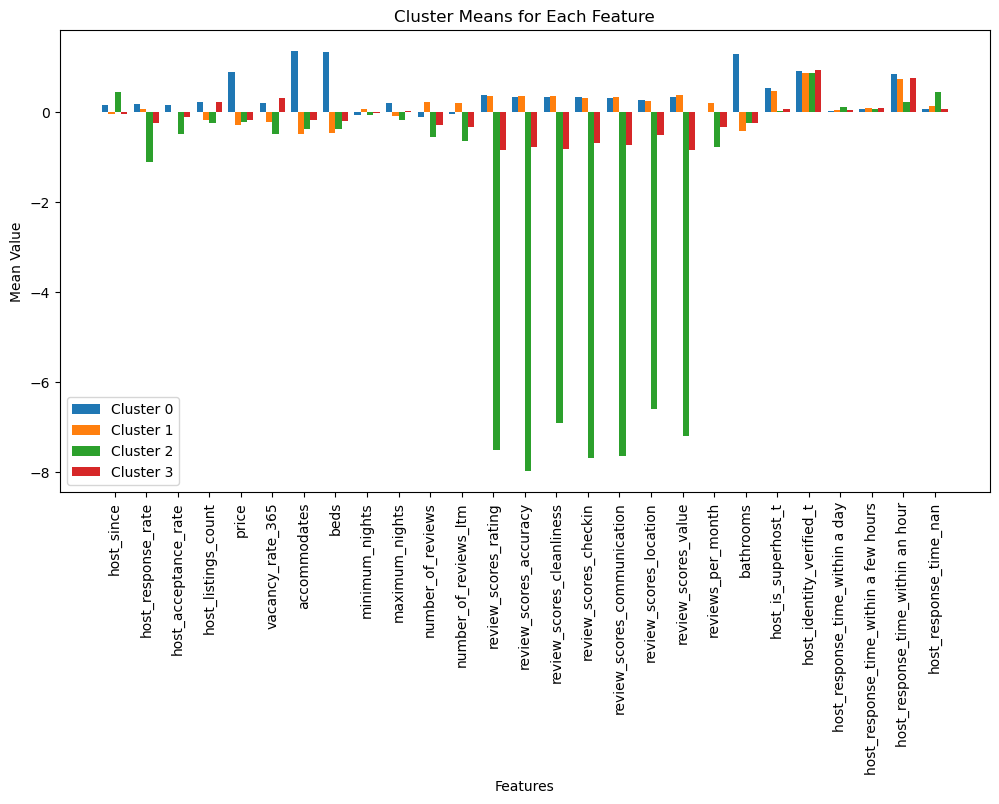

In [175]:
cluster_means = cluster_summary.copy()
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

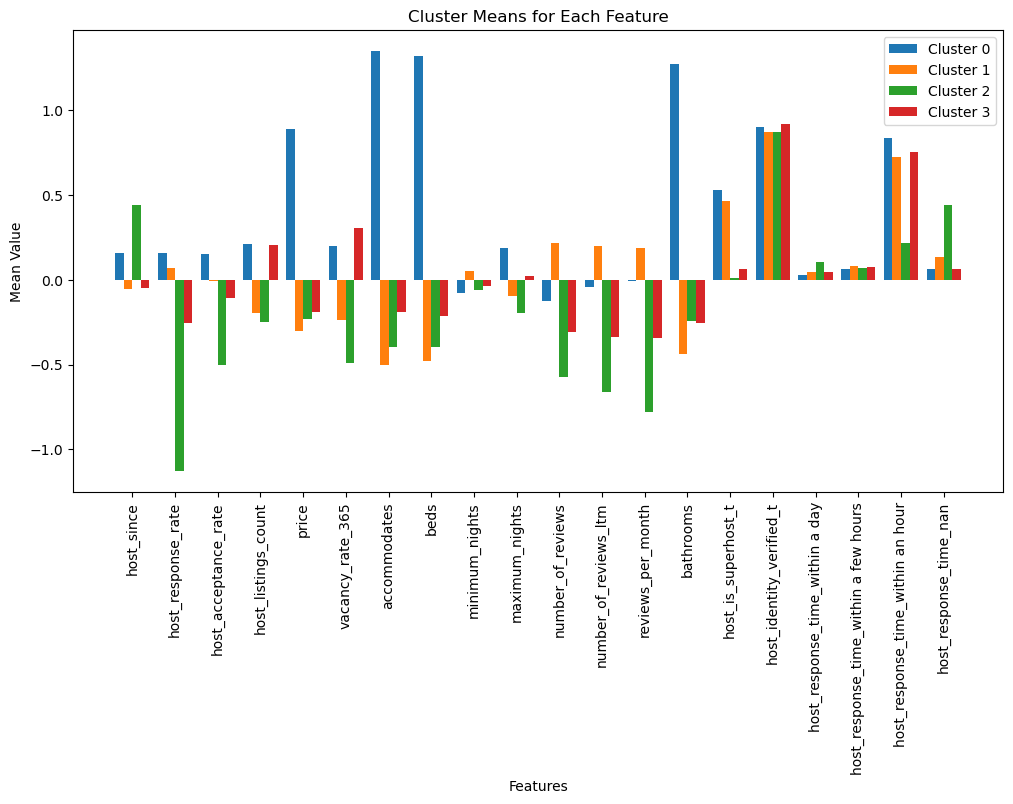

In [176]:
cluster_means = cluster_summary.copy()
cluster_means = cluster_means.drop(['review_scores_rating','review_scores_accuracy',
                                             'review_scores_cleanliness', 'review_scores_checkin', 
                                             'review_scores_communication','review_scores_location',
                                            'review_scores_value'], axis=1)
num_clusters = cluster_means.shape[0]
num_features = cluster_means.shape[1]

# Set the positions and width for the bars
positions = np.arange(num_features)
bar_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over clusters to plot each cluster's mean
for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    ax.bar(positions + i * bar_width, row, bar_width, label=f'Cluster {cluster}')

# Set the labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means for Each Feature')
ax.set_xticks(positions + bar_width * (num_clusters - 1) / 2)
ax.set_xticklabels(cluster_means.columns)
plt.xticks(rotation=90)
ax.legend()

# Show the plot
plt.show()

<h3>Cluster Interpretation</h3>
<br> Cluster 0: //
<br> Cluster 1: //
<br> Cluster 2: //
<br> Cluster 3: //

In [177]:
cluster_summary

,host_since,host_response_rate,host_acceptance_rate,host_listings_count,price,vacancy_rate_365,accommodates,beds,minimum_nights,maximum_nights,...,review_scores_location,review_scores_value,reviews_per_month,bathrooms,host_is_superhost_t,host_identity_verified_t,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.158873,0.160539,0.152422,0.213083,0.888040,0.198794,1.349592,1.321142,-0.077126,0.190496,...,0.249659,0.328013,-0.009032,1.273835,0.528730,0.902343,0.025894,0.063132,0.838718,0.065845
1,-0.052812,0.071077,-0.007227,-0.195303,-0.300219,-0.235275,-0.502793,-0.479736,0.053519,-0.092892,...,0.230736,0.371441,0.186589,-0.438783,0.464136,0.871000,0.047892,0.082763,0.724123,0.131649
2,0.442404,-1.127413,-0.501132,-0.247439,-0.231513,-0.489648,-0.395071,-0.394671,-0.062928,-0.194104,...,-6.605008,-7.202204,-0.781424,-0.243049,0.008621,0.870690,0.103448,0.068966,0.215517,0.439655
3,-0.047601,-0.255441,-0.108480,0.205021,-0.187267,0.303368,-0.190974,-0.211513,-0.036189,0.020149,...,-0.512750,-0.847003,-0.343046,-0.254707,0.062966,0.919482,0.044976,0.072839,0.754278,0.065599


In [178]:
cluster_summary_1 = cluster_summary.copy().drop(['review_scores_accuracy',
                                             'review_scores_cleanliness', 'review_scores_checkin', 
                                             'review_scores_communication','review_scores_location',
                                            'review_scores_value'], axis=1)

output_dir = 'host_cluster_images'
os.makedirs(output_dir, exist_ok=True)

# Find the overall min and max values for the y-axis
y_min = cluster_summary_1.min().min()
y_max = cluster_summary_1.max().max()

# Loop through each cluster and create a graph
for index, row in cluster_summary_1.iterrows():
    plt.figure()
    row.plot(kind='bar')
    plt.title(f'Cluster {index}')
    plt.xlabel('Features')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=90)
    
    # Set consistent y-axis limits & tight layout
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    
    # Save the plot as an image
    filename = os.path.join(output_dir, f'cluster_{index}.png')
    plt.savefig(filename)
    plt.close()
    
directory = output_dir

files = os.listdir(directory)
filenames = []
filenames = [file for file in files if os.path.isfile(os.path.join(directory, file))]


os.chdir(directory)
with imageio.get_writer('clusters.gif', mode='I', loop =0, duration=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        for idx in range(0,75): #workaround for image duration
            writer.append_data(image)
os.chdir('..')